In [1]:
import random
import numpy as np
import json

#Pytorch
import torch
import torch.nn as nn

#from model import NeuralNet
#NLP 
import nltk
#from nltk_utils import bag_of_words, tokenize
# nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

# Natural Language Processing

In [405]:
# Function to split the sentence into array of words(token). 
# this is array also can contain punctuation, number, character
def tokenize_sentence(sentence):
    after_tokenized = nltk.word_tokenize(sentence)
    return after_tokenized

# stemming function which is used to find the root for of the word
def stemming(word):
    after_stemming = stemmer.stem(word.lower())
    return after_stemming

# BagofWords function which is used to assign 1 for words in bag of words, 
# if the word from the pattarn sentence is available in the bag of words
# and it assign zero for the remaining words in bag of words
def bagOfWords(pattern_sentence, bagwords):
    #stem each word from the pattern
    pattern_words = [stemming(pattern_word) for pattern_word in pattern_sentence]
    #first initialize all words in bag with zero
    bag_with_binary_value = np.zeros(len(bagwords))
    for index, bgword in enumerate(bagwords):
        if bgword in pattern_words:
            bag_with_binary_value[index] = 1
    return bag_with_binary_value        

In [480]:
with open('intents.json', 'r') as f:
    intents = json.load(f)

In [481]:
with open('intents.json', 'r') as f:
    intents = json.load(f)
all_pattern_words = []
intents_tags = []
tokenizedpattern_tags = []

# loop each sentence in the intents patterns
for intent in intents['intents']:
    intent_tag = intent['tag']
    #add the each tag to intents_tags list
    intents_tags.append(intent_tag)
    for pattern in intent['patterns']:
        #tokenize the each word in the pattern sentence
        w = tokenize_sentence(pattern)
        # add tokenzied pattern words in all_pattern_words list
        all_pattern_words.extend(w)
        # words_tags contains the words and its tag
        tokenizedpattern_tags.append((w,intent_tag))

#stemming and convert the words to lower case
punctuation_removal = ['.', '!','?',',']
all_pattern_words = [stemming(w) for w in all_pattern_words if w not in punctuation_removal]
# sorting the words and remove duplicate words
all_pattern_words = sorted(set(all_pattern_words))
intents_tags = sorted(set(intents_tags))

print(len(tokenizedpattern_tags), "patterns")
print(len(intents_tags), "tags:", intents_tags)
print(len(all_pattern_words), "unique stemmed words:", all_pattern_words)

# create training data
X_train = []
Y_train = []
for (tokenized_pat, tag) in tokenizedpattern_tags:
    # x_train: bag the words for each pattern
    bag_word = bagOfWords(tokenized_pat, all_pattern_words)
    X_train.append(bag_word)
    # Y_train - Pytorch crossentropy wants only class lables
    class_label = intents_tags.index(tag)
    Y_train.append(class_label)
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)




211 patterns
37 tags: [' Store location', ' collect from store', 'Add item', 'Cancel order', 'General statement', 'Invoice', 'Mixer, wet Grinder brand', 'Mixer,wet Grinder', 'Mixer,wet Grinder Price', 'Pressure Cooker', 'Pressure Cooker brand', 'Price', 'Product Available', 'Product check', 'change delivery time', 'complaints', 'contact number', 'coupon', 'delivery', 'discount', 'expire date', 'free delivery', 'funny', 'goodbye', 'greeting', 'items', 'ok', 'outside stockholm', 'payments methods', 'request product from india', 'return product', 'shop open time', 'swish number', 'thanks', 'trouble to place order ', 'vegetables', 'website problem']
201 unique stemmed words: ["'s", 'a', 'accept', 'add', 'address', 'afternoon', 'aha', 'am', 'amount', 'and', 'ani', 'anyon', 'are', 'at', 'avail', 'avil', 'back', 'bad', 'base', 'be', 'befor', 'best', 'bill', 'brand', 'bug', 'by', 'bye', 'ca', 'call', 'can', 'cancel', 'cancl', 'card', 'cash', 'charg', 'close', 'collect', 'come', 'confirm', 'con

In [482]:
# Hyper Parameters
 
epochs = 1000
batch_size = 15
learning_rate = 0.001
input_layer = len(X_train[0])
output_layer = len(intents_tags)
hidden_layer = round(output_layer*(2/3))
print(input_layer,hidden_layer, output_layer)

201 25 37


In [483]:
from torch.utils.data import Dataset, DataLoader

In [484]:
class Chatdata(Dataset):
    def __init__(self):
        self.samples = len(X_train)
        self.x_dataset = X_train
        self.y_dataset = Y_train 
        
    # indexing can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_dataset[index], self.y_dataset[index]   
    
    # call len(dataset) to return the size
    def __len__(self):
        return self.samples
    
dataset = Chatdata() 


In [485]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.l2 = nn.Linear(hidden_size, hidden_size) 
        self.l3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        # no activation and no softmax at the end
        return out

In [486]:
train_loader = DataLoader(dataset=dataset, batch_size=batch_size,
                          shuffle=True, num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NeuralNet(input_layer, hidden_layer, output_layer).to(device)

In [487]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model

In [488]:
Loss_list = []
epoch_list = []
train_acc = []
for epoch in range(epochs):
    for (train_load_words, train_load_labels) in train_loader:
        #print("train_load_words",train_load_words)
        #print("train_load_labels",train_load_labels)
        train_load_words = train_load_words.to(device)
        train_load_labels = train_load_labels.to(dtype=torch.long).to(device)
        
        # Forward pass
        targets = model(train_load_words.float())
        # if y would be one-hot, we must apply
        # labels = torch.max(labels, 1)[1]
        loss = criterion(targets, train_load_labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if(epoch+1) % 100 ==0:
#         tr_acc= 100.* train_load_labels * len(train_load_words[0]) / len(train_loader.dataset)
#         train_acc.append(tr_acc)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        epoch_list.append(epoch+1)
        Loss_list.append(loss.item())
print(f'final loss: {loss.item():.4f}')

data = {
"model_state": model.state_dict(),
"input_layer": input_layer,
"hidden_layer": hidden_layer,
"output_layer": output_layer,
"all_pattern_words": all_pattern_words,
"intents_tags": intents_tags
}

FILE = "data.pth"
torch.save(data, FILE)

print(f'training complete. file saved to {FILE}')        

Epoch [100/1000], Loss: 0.0118
Epoch [200/1000], Loss: 0.0016
Epoch [300/1000], Loss: 0.0003
Epoch [400/1000], Loss: 0.0001
Epoch [500/1000], Loss: 0.0001
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0001
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000
final loss: 0.0000
training complete. file saved to data.pth


In [489]:
Loss_list

[0.011783872731029987,
 0.0016365956980735064,
 0.0002525725867599249,
 0.00010656742961145937,
 7.676783570786938e-05,
 2.074220174108632e-05,
 9.881961887003854e-05,
 1.9073468138230965e-06,
 1.1920922133867862e-06,
 7.152555099310121e-07]

In [465]:
epoch_list

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

Text(0, 0.5, 'Loss')

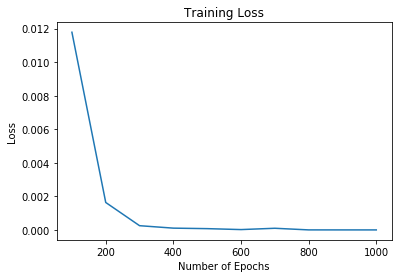

In [490]:
import matplotlib.pyplot as plt
plt.plot(epoch_list,Loss_list)
plt.title("Training Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")

In [491]:
FILE = "data.pth"
data = torch.load(FILE)

input_layer = data["input_layer"]
hidden_layer = data["hidden_layer"]
output_layer = data["output_layer"]
all_pattern_words = data['all_pattern_words']
intents_tags = data['intents_tags']
model_state = data["model_state"]

model = NeuralNet(input_layer, hidden_layer, output_layer).to(device)
model.load_state_dict(model_state)
model.eval()

NeuralNet(
  (l1): Linear(in_features=201, out_features=25, bias=True)
  (l2): Linear(in_features=25, out_features=25, bias=True)
  (l3): Linear(in_features=25, out_features=37, bias=True)
  (relu): ReLU()
)

In [ ]:
bot_name = "Nila"
print("Let's chat! (type 'quit' to exit)")
print("")
print("If you want to become partner or looking for Job please write email to info@nila.se")
print("")
while True:
    # sentence = "do you use credit cards?"
    sentence = input("You: ")
    if sentence == "quit":
        break

    sentence = tokenize_sentence(sentence)
    X = bagOfWords(sentence, all_pattern_words)
    X = X.reshape(1, X.shape[0])
    X = torch.from_numpy(X).to(device)

    output = model(X.float())
    _, predicted = torch.max(output, dim=1)

    tag = intents_tags[predicted.item()]

    probs = torch.softmax(output, dim=1)
    prob = probs[0][predicted.item()]
#     print(probs)
#     print(prob)
#     print(predicted.item())
#     print(prob.item())
    if prob.item() > 0.9:
        for intent in intents['intents']:
            if tag == intent["tag"]:
                print(f"{bot_name}: {random.choice(intent['responses'])}")
    else:
        print(f'''{bot_name}: Thanks for contacting us. We've received your message and appreciate you reaching out. 

You can Whatsup us on +46727700345 for Order Enquires.''')

Let's chat! (type 'quit' to exit)

If you want to become partner or looking for Job please write email to info@nila.se

You: hi
Nila: Hey :-)
You: may i know the swish number
Nila: The swish number is 1230099770 
You: what is the customer support number
Nila: You can contact the customer support 072 770 0345 by whatsapp  
You: what product you have
Nila:  Please look at our website nilagroceries.se
You: ok 
Nila: Ok. any other questions?
You: thanks
Nila: Any time!
